In [1]:
import os
import sys
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np

# Make project root importable
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

In [2]:
from src.model_training import prepare_data, train_logistic_regression, train_random_forest
from src.evaluation import evaluate_model, recall_at_k

In [3]:
processed_path = os.path.join(project_root, "data", "processed", "telco_churn_processed.csv")
df = pd.read_csv(processed_path)
print("df shape:", df.shape)

df shape: (7043, 28)


In [4]:
X_train, X_test, y_train, y_test, preprocessor = prepare_data(df)

In [5]:
log_model = train_logistic_regression(X_train, y_train, preprocessor)
rf_model  = train_random_forest(X_train, y_train, preprocessor)

In [6]:
log_results = evaluate_model(log_model, X_test, y_test)
rf_results  = evaluate_model(rf_model,  X_test, y_test)

print("Logistic accuracy:", log_results["accuracy"])
print("Random Forest accuracy:", rf_results["accuracy"])

Logistic accuracy: 0.7842441447835344
Random Forest accuracy: 0.7700496806245565


In [7]:
print(log_results["classification_report"] )

              precision    recall  f1-score   support

       False       0.82      0.91      0.86      1035
        True       0.63      0.45      0.53       374

    accuracy                           0.78      1409
   macro avg       0.73      0.68      0.69      1409
weighted avg       0.77      0.78      0.77      1409



In [8]:
print(log_results["f1"])

0.525


In [9]:
#
print("log_model:", type(log_model))
print("rf_model :", type(rf_model))

print("log_results keys:", log_results.keys())
print("rf_results  keys:", rf_results.keys())

log_model: <class 'sklearn.pipeline.Pipeline'>
rf_model : <class 'sklearn.pipeline.Pipeline'>
log_results keys: dict_keys(['roc_auc', 'pr_auc', 'accuracy', 'precision', 'recall', 'f1', 'confusion_matrix', 'classification_report'])
rf_results  keys: dict_keys(['roc_auc', 'pr_auc', 'accuracy', 'precision', 'recall', 'f1', 'confusion_matrix', 'classification_report'])


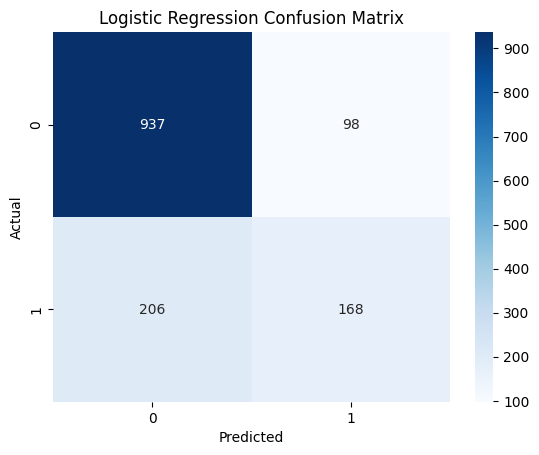

In [10]:
# Confusion matrix heatmap (Logistic Regression)
cm = log_results["confusion_matrix"]

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Logistic Regression Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [11]:
# ROC curve comparison (use models directly for probabilities)
y_prob_log = log_model.predict_proba(X_test)[:, 1]
y_prob_rf  = rf_model.predict_proba(X_test)[:, 1]

In [12]:
fpr_log, tpr_log, _ = roc_curve(y_test, y_prob_log)
roc_auc_log = auc(fpr_log, tpr_log)

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

In [13]:
rf_model.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [14]:
# Fitted pipeline already includes the preprocessor and classifier
rf_model.fit(X_train, y_train)

# 2. Get fitted preprocessor
preprocessor_fitted = rf_model.named_steps["preprocessor"]

# 3. Get all feature names using get_feature_names_out
# This works for both numeric and categorical features in a ColumnTransformer
try:
    feature_names = preprocessor_fitted.get_feature_names_out()
except:
    # fallback: combine numeric + categorical manually
    num_features = preprocessor_fitted.transformers_[0][2]
    cat_pipeline = preprocessor_fitted.transformers_[1][1]
    cat_encoder = cat_pipeline.named_steps["encoder"]
    cat_features = cat_encoder.get_feature_names_out(cat_pipeline.feature_names_in_)
    feature_names = list(num_features) + list(cat_features)

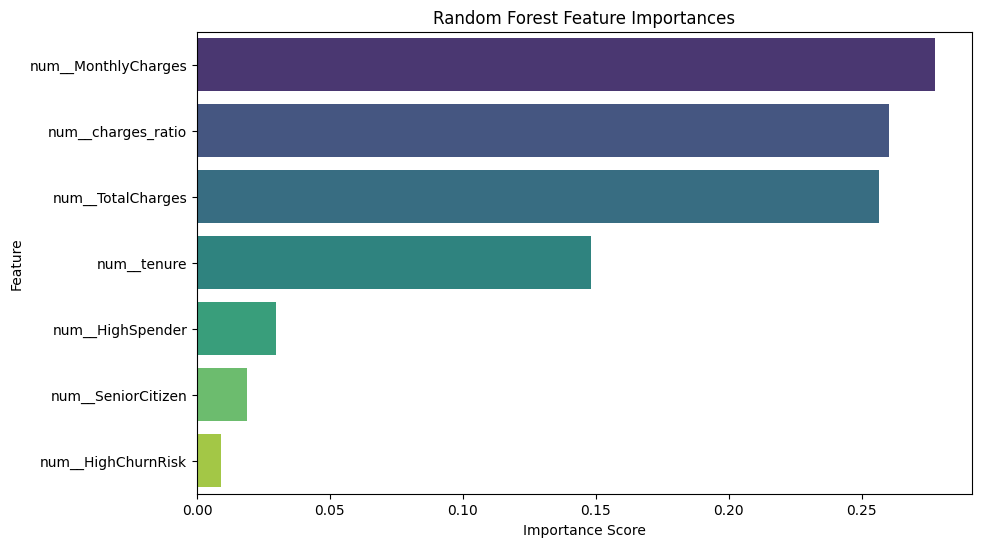

In [15]:
importances = rf_model.named_steps["classifier"].feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
sns.barplot(
    x=importances[indices],
    y=[feature_names[i] for i in indices],
    hue=[feature_names[i] for i in indices],  # assign y to hue
    palette="viridis",
    dodge=False,   # keep bars together
    legend=False   # remove legend
)
plt.title("Random Forest Feature Importances")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

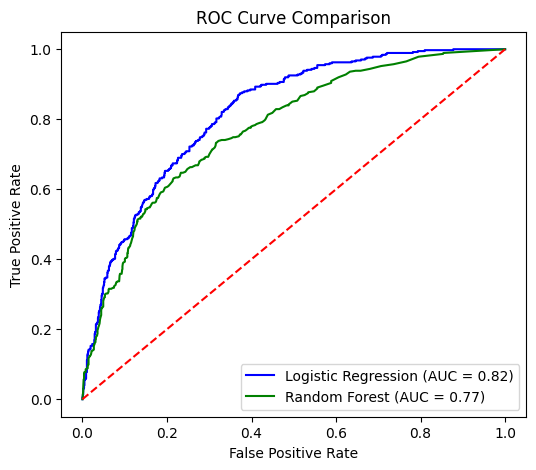

In [16]:
# ROC curves
plt.figure(figsize=(6, 5))
plt.plot(fpr_log, tpr_log, color="blue",  label=f"Logistic Regression (AUC = {roc_auc_log:.2f})")
plt.plot(fpr_rf,  tpr_rf,  color="green", label=f"Random Forest (AUC = {roc_auc_rf:.2f})")
plt.plot([0, 1], [0, 1], "r--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()

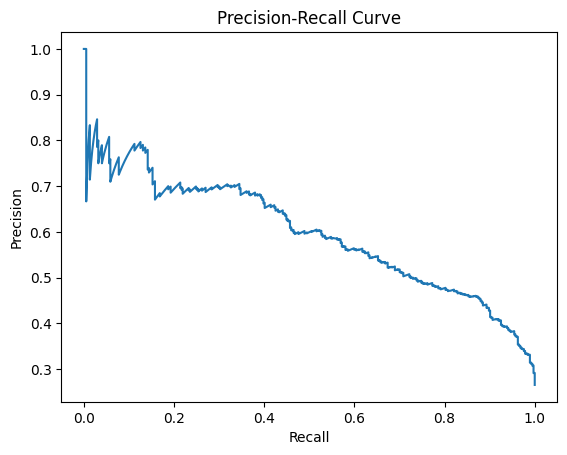

In [17]:
from sklearn.metrics import precision_recall_curve

def plot_pr(y_true, y_prob):
    precision, recall, _ = precision_recall_curve(y_true, y_prob)

    plt.figure()
    plt.plot(recall, precision)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.show()
    
plot_pr(y_test, y_prob_log)

In [18]:
precision, recall, thresholds = precision_recall_curve(y_test, y_prob_log)

In [19]:
print("Precision-Recall thresholds:", thresholds)

Precision-Recall thresholds: [0.00338908 0.00375316 0.00389768 ... 0.83454916 0.83741942 0.86399264]


In [20]:
print("Precision:", precision)
print("Recall:", recall)

Precision: [0.26543648 0.265625   0.26581379 ... 1.         1.         1.        ]
Recall: [1.         1.         1.         ... 0.00534759 0.0026738  0.        ]


In [21]:
print(thresholds[1]) # → gives you the cutoff

print(precision[1])
print(recall[1]) # → what happens at that cutoff

0.003753163131733769
0.265625
1.0


In [22]:
precision_adj = precision[:-1]
recall_adj = recall[:-1]

mask = (recall_adj >= 0.5) & (precision_adj >= 0.6)

optimal_threshold = thresholds[mask][0]

In [23]:
recall_20_log = recall_at_k(y_test, y_prob_log, k=0.2)
print("Logistic Regression Recall at 20%:", recall_20_log)

Logistic Regression Recall at 20%: 0.4572192513368984


In [24]:
recall_20_rf = recall_at_k(y_test, y_prob_rf, k=0.2)
print("Random Forest Recall at 20%:", recall_20_rf)

Random Forest Recall at 20%: 0.4385026737967914


In [25]:
# LIFT METRIC CALCULATION

import numpy as np


def lift_at_k(y_true, y_prob, k=0.2):
    """Return (precision_at_k, baseline_rate, lift_at_k) for top-k ranked customers."""
    y_true = np.asarray(y_true)
    y_prob = np.asarray(y_prob)

    n = y_true.shape[0]
    k_n = max(1, int(np.ceil(k * n)))

    top_idx = np.argsort(y_prob)[::-1][:k_n]

    precision_k = y_true[top_idx].mean()  
    baseline = y_true.mean()  
    lift = precision_k / baseline if baseline > 0 else np.nan

    return precision_k, baseline, lift


for k in [0.10, 0.20]:
    p_log, base, lift_log = lift_at_k(y_test, y_prob_log, k=k)
    p_rf, base, lift_rf = lift_at_k(y_test, y_prob_rf, k=k)

    print(
        f"\n--- Lift@{int(k * 100)}% (Top {int(k * 100)}% highest-risk customers) ---"
    )
    print(f"Baseline churn rate (random): {base:.3f}")
    print(
        f"Logistic: Precision@{int(k * 100)}% = {p_log:.3f}  | Lift = {lift_log:.2f}x"
    )
    print(f"RF      : Precision@{int(k * 100)}% = {p_rf:.3f}  | Lift = {lift_rf:.2f}x")


--- Lift@10% (Top 10% highest-risk customers) ---
Baseline churn rate (random): 0.265
Logistic: Precision@10% = 0.695  | Lift = 2.62x
RF      : Precision@10% = 0.674  | Lift = 2.54x

--- Lift@20% (Top 20% highest-risk customers) ---
Baseline churn rate (random): 0.265
Logistic: Precision@20% = 0.610  | Lift = 2.30x
RF      : Precision@20% = 0.585  | Lift = 2.20x


SHAP Explainability for Logistic Regression and Random Forest models

In [26]:
import shap
import numpy as np
import scipy.sparse as sp


def func_split_pipeline(pipeline):
    """Return (preprocessor, estimator) from a sklearn Pipeline-like object."""
    if hasattr(pipeline, "named_steps") and hasattr(pipeline, "steps"):
        steps = pipeline.named_steps

        pre = steps.get("preprocessor", None)

        if pre is None:
            for name, step in pipeline.steps[:-1]:
                if hasattr(step, "transform"):
                    pre = step
                    break

        est = pipeline.steps[-1][1]
        return pre, est

    return None, pipeline


def func_get_feature_names(pre, X):
    """Best-effort feature name recovery after preprocessing."""
    if pre is not None and hasattr(pre, "get_feature_names_out"):
        try:
            return np.array(pre.get_feature_names_out(), dtype=str)
        except Exception:
            pass

    if hasattr(X, "columns"):
        return np.array(X.columns, dtype=str)

    return None


def func_transform(pre, X):
    """Apply preprocessor transform if present; otherwise return X."""
    if pre is None:
        return X
    return pre.transform(X)


def func_sample_rows(X, n=2000, random_state=42):
    """Sample rows from DataFrame / ndarray / sparse matrix."""
    n = min(n, X.shape[0])

    if hasattr(X, "sample"):
        Xs = X.sample(n=n, random_state=random_state)
        idx = Xs.index
        return Xs, idx

    rng = np.random.RandomState(random_state)
    idx = rng.choice(np.arange(X.shape[0]), size=n, replace=False)
    return X[idx], idx


def func_align_y(y, idx):
    """Align y to sampled indices (works for pandas Series or numpy arrays)."""
    if hasattr(y, "loc"):
        return y.loc[idx]
    return y[idx]


def func_select_positive_class(shap_exp):
    """
    Ensure we explain the positive class (class=1) for classification outputs.
    Some SHAP versions return (n_samples, n_features, n_classes).
    """
    if hasattr(shap_exp, "values") and getattr(shap_exp.values, "ndim", 0) == 3:
        return shap_exp[..., 1]
    return shap_exp

Logistic SHAP shape: (1409, 7)


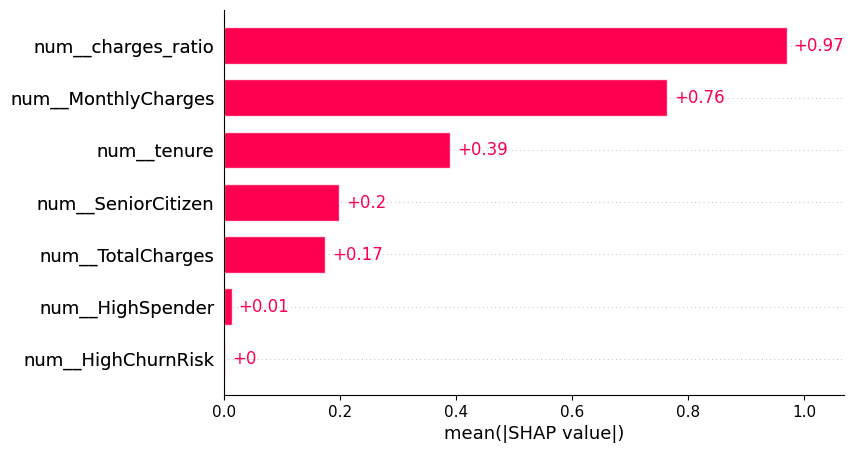

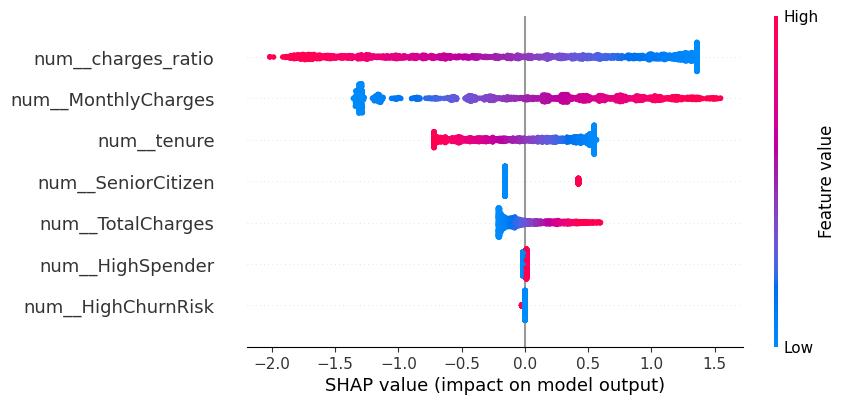

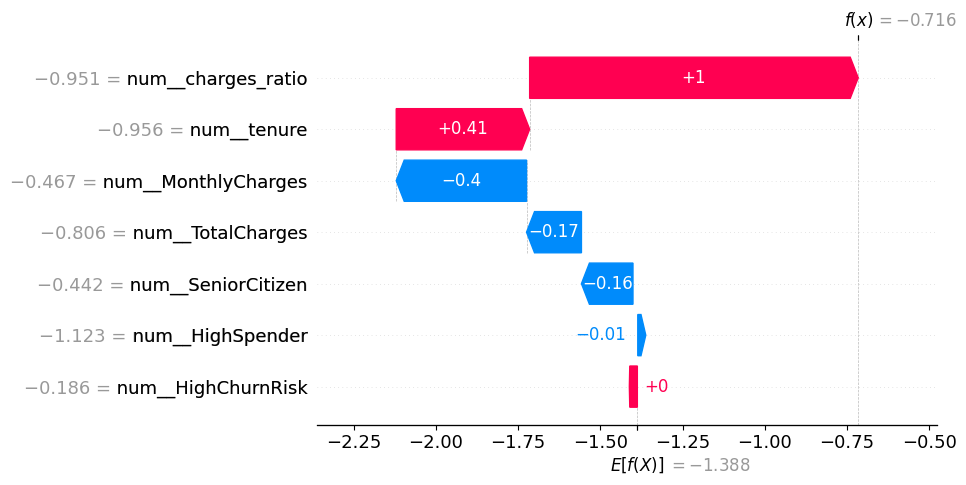

In [27]:
# For LOGISTIC REGRESSION

pre_log, est_log = func_split_pipeline(log_model)
if "preprocessor" in globals() and preprocessor is not None:
    pre_log = preprocessor

X_test_s, idx_s = func_sample_rows(X_test, n=2000, random_state=42)
y_test_s = func_align_y(y_test, idx_s)

X_train_t = func_transform(pre_log, X_train)
X_test_t  = func_transform(pre_log, X_test_s)

feature_names = func_get_feature_names(pre_log, X_train)

try:
    background = shap.utils.sample(X_train_t, 200, random_state=42)
except Exception:
    background = X_train_t

explainer_log = shap.Explainer(est_log, background, feature_names=feature_names)

shap_values_log = explainer_log(X_test_t)
shap_values_log = func_select_positive_class(shap_values_log)

print("Logistic SHAP shape:", shap_values_log.values.shape)

try:
    shap.plots.bar(shap_values_log, max_display=20)
    shap.plots.beeswarm(shap_values_log, max_display=20)
except Exception:
    X_plot = X_test_t.toarray() if (sp is not None and sp.issparse(X_test_t)) else X_test_t
    shap.summary_plot(shap_values_log.values, X_plot, feature_names=feature_names, max_display=20)

try:
    shap.plots.waterfall(shap_values_log[0], max_display=20)
except Exception:
    pass

 99%|===================| 2797/2818 [01:54<00:00]        

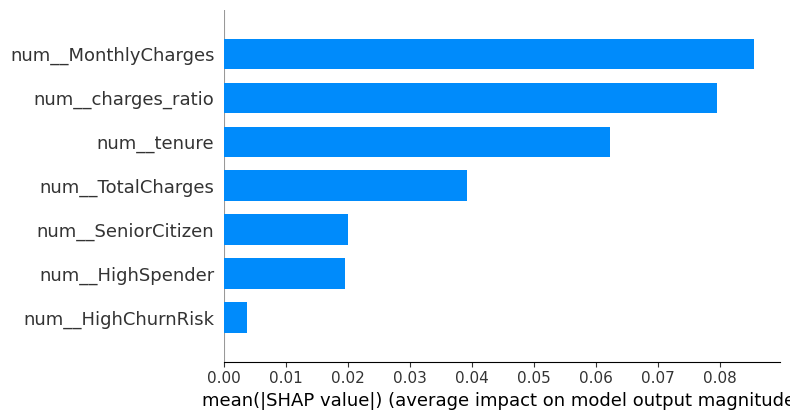

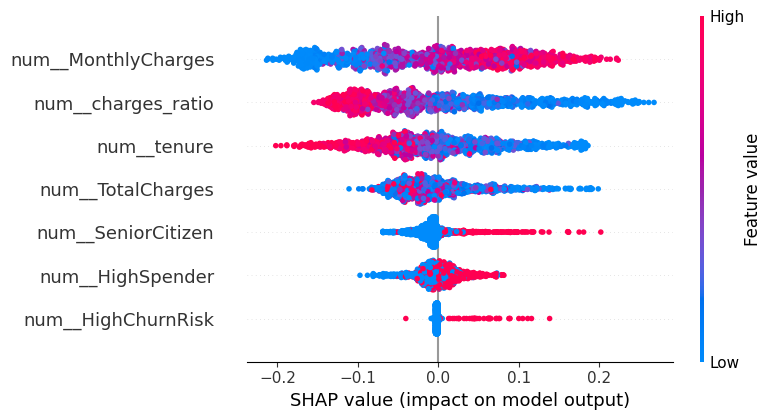

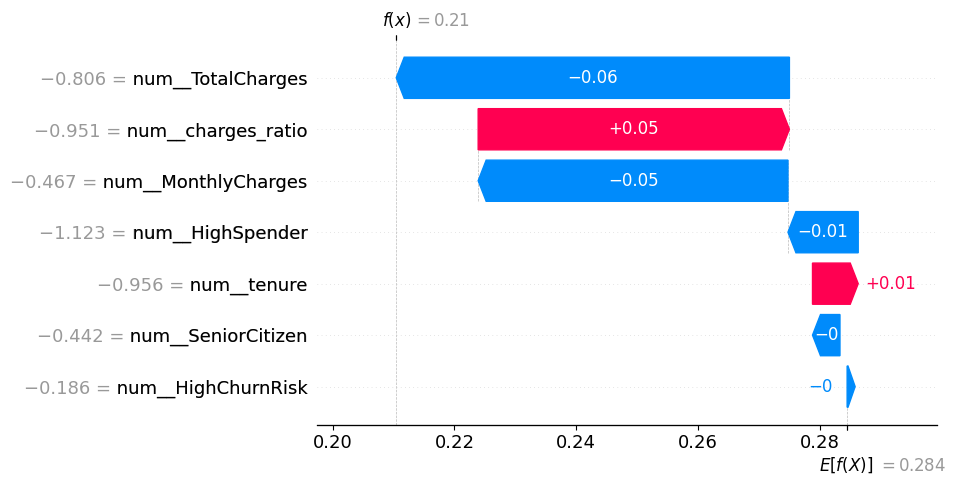

In [28]:
#RANDOM FOREST

import numpy as np

pre_rf, est_rf = func_split_pipeline(rf_model)

X_test_s, idx_s = func_sample_rows(X_test, n=2000, random_state=42)
y_test_s = func_align_y(y_test, idx_s)

X_train_t = func_transform(pre_rf, X_train)
X_test_t = func_transform(pre_rf, X_test_s)

feature_names = func_get_feature_names(pre_rf, X_train)

def _to_dense(X):
    if sp is not None and sp.issparse(X):
        return X.toarray()
    return X


X_train_bg = X_train_t
try:
    bg_idx = np.random.RandomState(42).choice(
        X_train_bg.shape[0], size=min(200, X_train_bg.shape[0]), replace=False
    )
    background = _to_dense(X_train_bg[bg_idx])
except Exception:
    background = _to_dense(X_train_bg)

X_test_dense = _to_dense(X_test_t)

try:
    explainer_rf = shap.TreeExplainer(
        est_rf, data=background, feature_names=feature_names, model_output="probability"
    )
except TypeError:
    explainer_rf = shap.TreeExplainer(
        est_rf, data=background, feature_names=feature_names
    )

shap_vals = explainer_rf.shap_values(X_test_dense)

if isinstance(shap_vals, list):
    shap_vals_pos = shap_vals[1]  # class 1
    base_val = (
        explainer_rf.expected_value[1]
        if isinstance(explainer_rf.expected_value, (list, np.ndarray))
        else explainer_rf.expected_value
    )
elif hasattr(shap_vals, "ndim") and shap_vals.ndim == 3:
    shap_vals_pos = shap_vals[:, :, 1]
    base_val = (
        explainer_rf.expected_value[1]
        if isinstance(explainer_rf.expected_value, (list, np.ndarray))
        else explainer_rf.expected_value
    )
else:
    shap_vals_pos = shap_vals
    base_val = explainer_rf.expected_value


if np.isscalar(base_val):
    base_values_rf = np.full(X_test_dense.shape[0], base_val)
else:
    base_values_rf = base_val

shap_values_rf = shap.Explanation(
    values=shap_vals_pos,
    base_values=base_values_rf,
    data=X_test_dense,
    feature_names=feature_names,
)

shap.summary_plot(
    shap_vals_pos,
    X_test_dense,
    feature_names=feature_names,
    plot_type="bar",
    max_display=20,
)

shap.summary_plot(
    shap_vals_pos, X_test_dense, feature_names=feature_names, max_display=20
)

try:
    exp0 = shap.Explanation(
        values=shap_vals_pos[0],
        base_values=base_val,
        data=X_test_dense[0],
        feature_names=feature_names,
    )
    shap.plots.waterfall(exp0, max_display=20)
except Exception as e:
    print("Waterfall plot skipped due to:", repr(e))

Comparing the output of SHAP for Logistic Regression vs Random Forest

In [29]:
def cal_mean_abs_shap(shap_exp):
    vals = shap_exp.values
    return np.mean(np.abs(vals), axis=0)

log_importance = cal_mean_abs_shap(shap_values_log)
rf_importance  = cal_mean_abs_shap(shap_values_rf)

if feature_names is None:
    feature_names = np.array([f"feature_{i}" for i in range(len(log_importance))])

top_n = 15
top_log_idx = np.argsort(log_importance)[::-1][:top_n]
top_rf_idx  = np.argsort(rf_importance)[::-1][:top_n]

print("Top features (Logistic Regression):")
for i in top_log_idx:
    print(f"  {feature_names[i]}: {log_importance[i]:.4f}")

print("\nTop features (Random Forest):")
for i in top_rf_idx:
    print(f"  {feature_names[i]}: {rf_importance[i]:.4f}")

Top features (Logistic Regression):
  num__charges_ratio: 0.9701
  num__MonthlyCharges: 0.7642
  num__tenure: 0.3899
  num__SeniorCitizen: 0.1987
  num__TotalCharges: 0.1745
  num__HighSpender: 0.0134
  num__HighChurnRisk: 0.0021

Top features (Random Forest):
  num__MonthlyCharges: 0.0854
  num__charges_ratio: 0.0796
  num__tenure: 0.0623
  num__TotalCharges: 0.0393
  num__SeniorCitizen: 0.0200
  num__HighSpender: 0.0195
  num__HighChurnRisk: 0.0037


In [30]:
import joblib
import os

models_dir = os.path.join(project_root, "models")
os.makedirs(models_dir, exist_ok=True)

best_model = log_model   # logistic regression pipeline
pipeline_path = os.path.join(models_dir, "churn_pipeline.joblib")
joblib.dump(best_model, pipeline_path)

print("Saved pipeline to:", pipeline_path)


Saved pipeline to: c:\Users\User\Predicting-Customer-Churn-in-Telecom_worksheet\models\churn_pipeline.joblib
